# Part 3: Forecasting with a Prophet 📉

https://youtu.be/pOYAXv15r3A

One piece of recent open software is facebook's `prophet`. This uses a model which is similar to a **generalised additive model** (GAM), a class of additive (linear) models with potentially non-linear components. 

The model is easily interpreted (as a sum of components) and simple to fit (parameters have a strightforward interpretation).
But if the hypothesis of the parametric model are not respected, the fitted model may seriously underfit.

You can read more about the underlying model [here](https://peerj.com/preprints/3190/).

As you are beginning to see time series forecasting can sometimes be as much an art as a science, and we know it takes quite some practice to become a good artist. The authors of the software had this in mind when they wrote it.  One of their aims is to provide software which can be used easily by those who have a little timeseries knowledge. Let's see how this goes....We will apply this software to the airline data now.

To install prophet I advise you to install a completely clean virtualenvironment with conda (you will find the instructions to do this [here](https://docs.conda.io/projects/conda/en/4.6.1/user-guide/tasks/manage-environments.html)).

Then you can install prophet with: `conda install -c conda-forge prophet`


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates

import seaborn as sns 
import matplotlib.style as style

# Example 1 - airline data

We setup the data as we had done so before in the ARIMA example.

In [2]:
from pmdarima.datasets import load_airpassengers

START_DATE = '1949-01-01'
airline = load_airpassengers(as_series=True)

#there's no datetimeindex from the bundled dataset. So let's add one.
airline.index= pd.date_range(
    START_DATE, 
    periods=len(airline), 
    freq='MS'
)

In [3]:
def ts_train_test_split(data, split_date):
    '''
    Split time series into training and test data
    
    Parameters:
    -------
    data - pd.DataFrame - time series data.  Index expected as datatimeindex
    split_date - the date on which to split the time series
    
    Returns:
    --------
    tuple (len=2) 
    0. pandas.DataFrame - training dataset
    1. pandas.DataFrame - test dataset
    '''
    train = data.loc[data.index < split_date]
    test = data.loc[data.index >= split_date]
    return train, test

In [4]:
#for cv need all of the training data joined together.
airline_adj = airline / airline.index.days_in_month

train, test = ts_train_test_split(airline_adj, '1960-01-01')
train_log, test_log = np.log(train), np.log(test) # get logged values for arima model


## Forecasting with prophet

Fitting a basic model and making predictions is very simple with `prophet`.

In [7]:
from prophet import Prophet
pd.plotting.register_matplotlib_converters()

Training data is expected in this df format below.

In [8]:
train_df = pd.DataFrame(train).reset_index().rename(columns = {0:'y','index':'ds'})

In [9]:
train_df.tail()

,ds,y
127,1959-08-01,18.032258
128,1959-09-01,15.433333
129,1959-10-01,13.129032
130,1959-11-01,12.066667
131,1959-12-01,13.064516


Fit model...

In [14]:
model = Prophet()
model.fit(train_df)
pass

09:22:10 - cmdstanpy - INFO - Chain [1] start processing


09:22:10 - cmdstanpy - INFO - Chain [1] done processing


Make predictions...

In [ ]:
future = model.make_future_dataframe(
    periods=12, 
    freq='MS', 
    include_history=True
) 
#create a dataframe with the prediction datetimes we want
future.head()

,ds
0,1949-01-01
1,1949-02-01
2,1949-03-01
3,1949-04-01
4,1949-05-01


In [12]:
forecast = model.predict(future)
y_pred = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds')

Plot predictions...

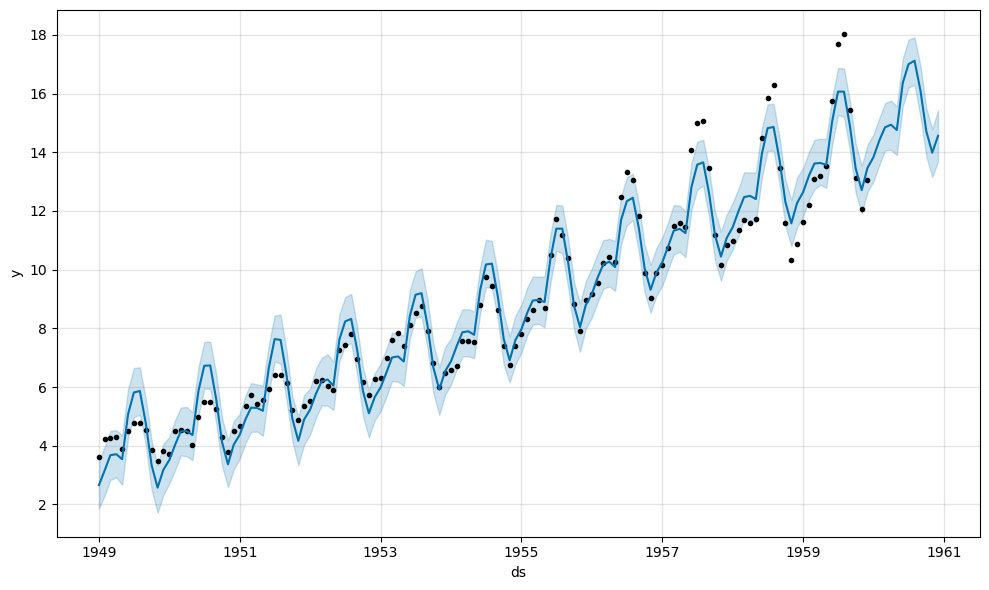

In [13]:
fig = model.plot(forecast)
# test.plot(style='.r')

Evaluating this baseline model error on test set...

In [15]:
def mean_absolute_percentage_error(y_true, y_pred): 
    '''
    MAPE

    Parameters:
    --------
    y_true -- np.array actual observations from time series
    y_pred -- the predictions to evaluate

    Returns:
    -------
    float, scalar value representing the MAPE (0-100)
    '''
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [16]:
mean_absolute_percentage_error(
    test.values , 
    forecast['yhat'][-12:])

np.float64(6.6175663010646595)

We at least see it beats the naive model scores  that we saw in the last notebook (from the unlogged data). Not bad for only several lines of code. But looking at the plot it is clearly not fitting well. We should use cross validation to find a better fitting model (before we evaluated in the test set!).

## Cross validation in prophet

There are cross validation functions in `prophet` that take care of time series data and can perform adjustable rolling windows as we had previously seen in other time series cross validation functions.

In [40]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [41]:
model = Prophet()
model.fit(train_df)
df_cv = cross_validation(
    model, 
    initial='1461 days', 
    period='365 days', 
    horizon = '365 days'
)

09:55:41 - cmdstanpy - INFO - Chain [1] start processing
09:55:41 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]09:55:41 - cmdstanpy - INFO - Chain [1] start processing
09:55:41 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:01,  3.59it/s]09:55:41 - cmdstanpy - INFO - Chain [1] start processing
09:55:42 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:00<00:01,  2.22it/s]09:55:42 - cmdstanpy - INFO - Chain [1] start processing
09:55:42 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  2.69it/s]09:55:42 - cmdstanpy - INFO - Chain [1] start processing
09:55:42 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:01<00:01,  1.89it/s]09:55:43 - cmdstanpy - INFO - Chain [1] start processing
09:55:43 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:02<00:00,  2.59it/s]09:55:43 - cmdstanpy - INFO - Chain [1] start processing
09:

In [42]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1954-01-01,7.374734,7.093127,7.623504,6.580645,1953-12-02
1,1954-02-01,8.073018,7.820350,8.325896,6.714286,1953-12-02
2,1954-03-01,8.316081,8.054897,8.603504,7.580645,1953-12-02
3,1954-04-01,8.248502,7.979712,8.511604,7.566667,1953-12-02
4,1954-05-01,8.062861,7.798241,8.313963,7.548387,1953-12-02


A function for performance metrics and plotting...

In [43]:
df_p = performance_metrics(df_cv)

In [44]:
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,61 days,0.732262,0.855723,0.708347,0.079037,0.071686,0.074323,0.380952
1,62 days,0.901625,0.949539,0.825398,0.085384,0.085915,0.080362,0.285714
2,89 days,0.745211,0.863256,0.713927,0.075639,0.085915,0.071439,0.333333
3,90 days,0.578488,0.760584,0.585130,0.054793,0.041156,0.052426,0.571429
4,120 days,0.474823,0.689074,0.545189,0.054868,0.050609,0.053033,0.500000


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ML6/lib/python3.12/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ML6/lib/python3.12/site-packages/prophet/plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


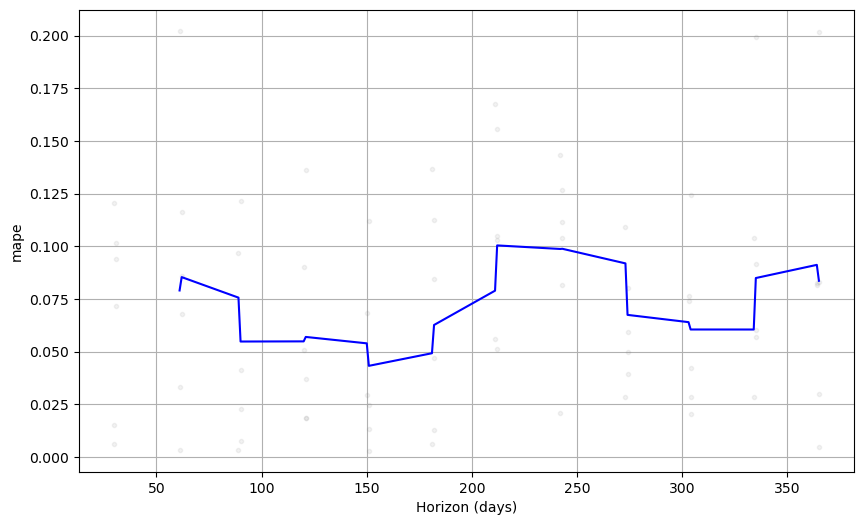

In [45]:
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()

The plot above is the standard output plot of the CV from `prophet`. It is different to what we have looked at before. Each grey point represents a prediction, made on a particular month. Because we made predictions over several horizons each are plotted on the graph. At around horizon 30 for example we see each of the plots over the first month of each of the 6, 12 month validations. The blue line shows a rolling window of the mape scores 'averaged' over the cv predictions. More info [here](https://facebook.github.io/prophet/docs/diagnostics.html).

We are normally interested in the mean and std of the MAPE scores found at each window. This can be calculated from the dataframe returned from the `cross_validation` function above, using the function below. 

In [46]:
def mape_performance_calc(df_cv):
    " function to replace prophet cv 'performance metrics' function"
    df_cv['mape'] = abs(df_cv['y'] - df_cv['yhat']) /df_cv['y'] # make column with individual abs normalised values
    results = df_cv.groupby(['cutoff']).mean() # finish mape calc for each of the folds (distinguised in 'cutoff' column of df_cv)
    results = results.describe() # sumarise folds information
    results = results['mape']# # return only mape column
    print(f"MAPE of {results['mean']*100:.1f}% with std of {results['std']*100:.1f}%." )
    print("-"*10)
    return(results)

mape_performance_calc(df_cv)

MAPE of 7.2% with std of 2.1%.
----------


count    6.000000
mean     0.072167
min      0.052698
25%      0.059261
50%      0.066481
75%      0.077062
max      0.109897
std      0.020711
Name: mape, dtype: float64

We find a MAPE of ~7.2% with std ~2%. This would have estimated the error we saw on the test set to a good degree.

## Hyper-parameters

The model plot we saw earlier did not fit very well to the train data. We can change the model assumptions (like hyper-parameters) to change how well it is fitting the train data.

`Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=25,
    changepoint_range=0.8,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
)`

**TASK**

* Try changing some of these. [This](https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3) blog is very useful in explaining the parameters and what they do.
* Find at least one change which improves your model cross validation score

In [76]:
#### your solution here 
model=Prophet(
    growth='linear', #no
    changepoints=None, #no
    n_changepoints=10, #25
    changepoint_range=0.8, #no result
    changepoint_prior_scale=20, #10 to 30

    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative', #additive
    seasonality_prior_scale=25, #no impact

    holidays=None, #no because monthly data
    holidays_prior_scale=10.0, #no holidays
    
    mcmc_samples=0, # maximum a posteriori
    interval_width=0.8,

    uncertainty_samples=1000,
    stan_backend=None,
).add_seasonality(name="yearly", period=365.25, fourier_order=10, prior_scale=25)

model.fit(train_df)
df_cv = cross_validation(
    model, 
    initial='1461 days', 
    period='365 days', 
    horizon = '365 days'
)
print("\n")
mape_performance_calc(df_cv)

10:13:45 - cmdstanpy - INFO - Chain [1] start processing
10:13:45 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]10:13:45 - cmdstanpy - INFO - Chain [1] start processing
10:13:45 - cmdstanpy - INFO - Chain [1] done processing
10:13:45 - cmdstanpy - INFO - Chain [1] start processing
10:13:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:00<00:00,  9.87it/s]10:13:45 - cmdstanpy - INFO - Chain [1] start processing
10:13:45 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:00<00:00,  6.98it/s]10:13:45 - cmdstanpy - INFO - Chain [1] start processing
10:13:46 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:00<00:00,  6.25it/s]10:13:46 - cmdstanpy - INFO - Chain [1] start processing
10:13:46 - cmdstanpy - INFO - Chain [1] done processing
10:13:46 - cmdstanpy - INFO - Chain [1] start processing
10:13:46 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 6/6 [00:00<00:00,  8



MAPE of 5.2% with std of 1.9%.
----------


count    6.000000
mean     0.052446
min      0.028117
25%      0.042747
50%      0.052532
75%      0.056692
max      0.083930
std      0.018852
Name: mape, dtype: float64